In [33]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912

In [34]:
stat_ls = {'Col': [ '2004-08-01', '2019-03-06']}
#put all starts and ends here! 

## Collm

In [35]:
alt_jul = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
    106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'

In [36]:
xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Col/Meteor_radar_Col_GW_201903.h5', group='info')['day']

<xarray.DataArray 'day' (phony_dim_0: 144, phony_dim_1: 1)>
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.]])
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    day:      vector to constuct date and time

In [37]:
station = 'Col'
infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
ds_jul = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = 'wind', combine='nested', parallel = True)
ds_jul = ds_jul.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
ds_jul['alt'] = alt_jul
ds_jul['alt'].attrs['units'] = 'km'
# change time range according to meteor radar station
ds_jul['time'] = pd.date_range(start = '2004-08-01', end = '2019-03-06', periods = ds_jul.time.shape[0]) 
ds_jul

,Array,Chunk
Bytes,26.61 MB,154.75 kB
Shape,"(127944, 26)","(744, 26)"
Count,528 Tasks,176 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,26.61 MB,154.75 kB
Shape,"(127944, 26)","(744, 26)"
Count,528 Tasks,176 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


## Wind data

In [58]:
var = 'u'
uvar= ds_jul[var]
var = 'v'
vvar= ds_jul[var]
wind=np.sqrt(uvar**2 + vvar**2)
wind_monthly=wind.resample(time='1M').mean('time')


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


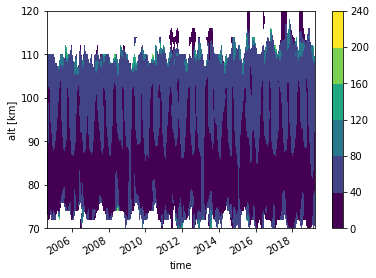

In [59]:

wind_monthly.plot.contourf(x='time',robust= False)



/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


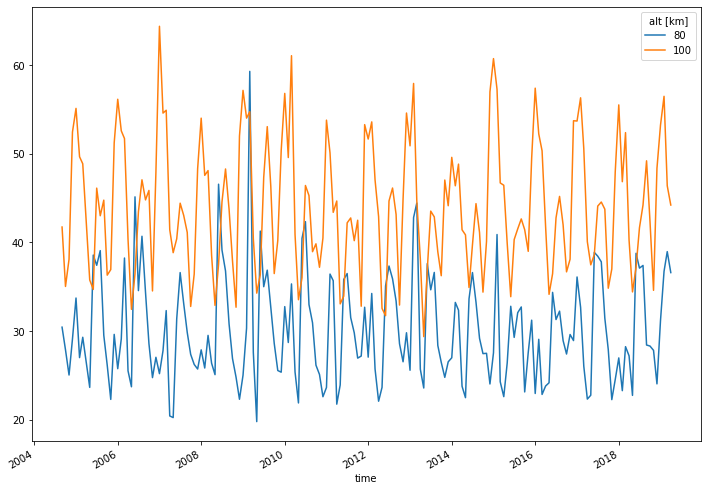

In [64]:
wind_monthly.sel(alt = [80,90,100], method = 'nearest').plot(size=8, hue ='alt')
#wind_monthly.time

In [48]:
wind.time

<xarray.DataArray 'time' (time: 127944)>
array(['2004-08-01T00:00:00.000000000', '2004-08-01T00:59:59.352836810',
       '2004-08-01T01:59:58.705673620', ..., '2019-03-05T22:00:01.294326400',
       '2019-03-05T23:00:00.647163200', '2019-03-06T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2004-08-01 ... 2019-03-06

### Gravity waves

In [17]:
var = 'u'
da_jul_gwu = ds_jul[var]-ds_jul[f'{var}_fil']
var = 'v'
da_jul_gwv = ds_jul[var]-ds_jul[f'{var}_fil']
da_jul_gw_total = 0.5*(da_jul_gwu**2+ da_jul_gwv**2) # kinetic energy

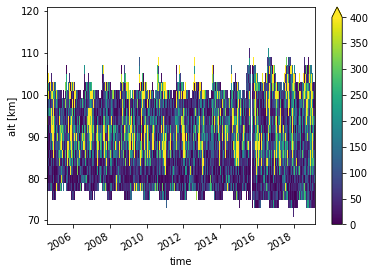

In [7]:
da_jul_gw_total.plot(x = 'time', robust = True, vmax = 400, vmin = 0)

#### Climatology calculation

In [8]:
da_jul_gw_total_clim = da_jul_gw_total.groupby('time.month').mean('time').load()
da_jul_gw_total_clim

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (month: 12, alt: 26)>
array([[         nan,  25.0896    ,  59.55092713,  54.13131604,
         51.54443126,  51.78077695,  89.6415676 , 159.18636277,
        233.23164567, 280.89802007, 298.26921526, 274.67603267,
        215.28448981, 175.65235654, 224.4256624 , 311.24480699,
        361.79118984, 424.30559261, 156.522075  ,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  60.01072757,  54.99272038,
         49.46674507,  42.93663124,  71.2284486 , 132.93989776,
        193.49567757, 227.90857196, 238.39160926, 220.34910958,
        169.73347494, 132.2930217 , 154.57804044, 252.90574723,
        281.57207553,  92.93885   ,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  51.0377084 ,  55.03524012,
         52.05643102,  39.55903276,  51.01840142,  99.16345214,
        147.6451435 , 167.99819707, 168.68480842, 151.18173998,
        112.93860028,  81.08890437,  96.45285674, 144.97893843,
        186.0600981 ,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,  68.60531666,
         60.23352586,  46.18497457,  47.97712761,  90.74191282,
        151.54408919, 183.84204288, 185.55368296, 166.78148258,
        127.16479912,  90.72971898,  98.77529159, 127.15385729,
        180.89947827, 608.03912857,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,  94.2048612 ,
         92.90698728,  83.14976563,  60.31116918,  85.48543142,
        150.64684322, 189.97338563, 176.0463802 , 130.48852463,
         90.00028982,  72.66012359,  90.20232891, 127.65739765,
        186.8702364 ,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, 107.14479289,
        101.5451145 ,  93.12264066,  58.10843503,  60.45747038,
         96.82627154, 122.63080098, 116.65647351,  95.06214929,
         76.10098778,  64.84924326,  77.29919583, 102.22970495,
        112.17141627, 111.86418333,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,  91.30391827,
         94.37304941,  78.67726843,  53.38855776,  60.22416375,
         90.37973663, 112.60222356, 112.13871381, 101.21585483,
         94.69615181,  92.0718059 , 109.06783194, 138.41285349,
        154.37510365, 178.94897329, 157.08834592,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,  97.53157543,
         79.14814293,  58.49018459,  50.11009179,  79.2540115 ,
        117.46984895, 138.05363483, 139.57817789, 135.44806913,
        135.88641109, 139.90601406, 149.09481161, 166.90998559,
        176.52358044, 188.90042471, 202.70746071, 177.76022635,
        113.4426875 ,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  67.45046912,  75.21606723,
         69.2625898 ,  46.18642615,  56.39628837, 106.37010843,
        160.71960871, 187.44079398, 192.30087931, 192.93294127,
        190.61469811, 186.25767207, 181.17842908, 186.52273052,
        173.63585535, 154.96100448, 141.48430859,  91.17508333,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  62.58073523,  69.4676786 ,
         66.67082925,  47.71181422,  61.12079448, 109.88019191,
        159.36060693, 183.38279758, 191.851

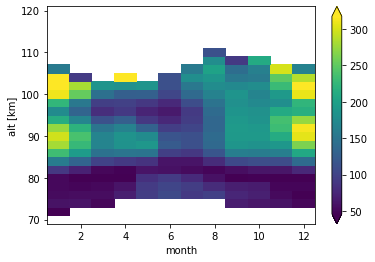

In [9]:
da_jul_gw_total_clim.plot(x = 'month', robust = True)

In [10]:
station = 'Rio'
infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
ds_jul = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = 'wind', combine='nested', parallel = True)
ds_jul = ds_jul.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
ds_jul['alt'] = alt_jul
ds_jul['alt'].attrs['units'] = 'km'
ds_jul['time'] = pd.date_range(start = '2008-02-01', end = '2019-12-31', periods = ds_jul.time.shape[0])
ds_jul

,Array,Chunk
Bytes,21.73 MB,154.75 kB
Shape,"(104448, 26)","(744, 26)"
Count,429 Tasks,143 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,21.73 MB,154.75 kB
Shape,"(104448, 26)","(744, 26)"
Count,429 Tasks,143 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [11]:
var = 'u'
da_jul_gwu = ds_jul[var]-ds_jul[f'{var}_fil']
var = 'v'
da_jul_gwv = ds_jul[var]-ds_jul[f'{var}_fil']
da_jul_gw_total = 0.5*(da_jul_gwu**2+ da_jul_gwv**2)
da_jul_gw_total_clim = da_jul_gw_total.groupby('time.month').mean('time').load()
da_jul_gw_total_clim

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (month: 12, alt: 26)>
array([[ 41.81531367,  64.04820926,  67.60282636,  93.45854375,
        110.06930871,  87.25695988,  68.59153517,  65.51240996,
         89.72839526, 114.6534767 , 134.92361907, 153.99092273,
        177.16851117, 203.63246464, 210.31735187, 190.14857476,
        156.31951107, 138.23055459, 124.55688515,  98.05390728,
         83.12707443,  85.16202   ,  66.64138571,  65.4981625 ,
         66.20605946,          nan],
       [ 71.184675  ,  66.14892659,  77.20833475,  87.54769098,
         81.43526547,  64.63393454,  58.01104504,  73.73484522,
         97.5879744 , 113.73233146, 128.68373417, 136.28026827,
        153.68761062, 188.21270855, 211.92527098, 201.23997791,
        174.44235981, 146.92564665, 117.52522147,  95.56733953,
         79.89398451,  71.33099784,  64.79758646,  13.71424667,
         32.948     ,          nan],
       [ 39.415545  ,  61.84706415,  62.58690232,  73.92271124,
         60.97390702,  53.22675597,  71.78338515, 115.21802795,
        155.64954993, 178.38694082, 183.64435704, 178.72381073,
        180.57343934, 206.1365517 , 250.99024261, 257.34401994,
        212.22834239, 164.56155535, 126.72528297, 106.00044594,
         83.72513983,  73.2019605 ,  92.68767588,  70.84056154,
                 nan,          nan],
       [ 41.27668657,  54.53155367,  57.15001197,  57.19440569,
         46.01357516,  43.05755583,  61.27934519,  94.09454529,
        130.42355962, 155.72878902, 177.58292646, 211.04871477,
        271.69135345, 374.56678611, 491.55549222, 505.03171215,
        371.48897931, 230.76573884, 157.29714353, 131.60114452,
        100.52912159,  77.45123965,  66.07808636,  80.5730971 ,
         91.5948    ,  75.90288158],
       [ 39.9773    ,  77.14773478,  63.72528709,  54.03976872,
         45.72017871,  51.84718984,  74.677513  , 108.06149884,
        143.0969447 , 177.42744195, 218.13860827, 279.02277519,
        365.38661411, 488.51932911, 589.73309907, 552.85892159,
        394.43141499, 246.99572856, 176.86848184, 139.32636667,
        121.76455473,  98.76562515,  93.85856351,  86.10531444,
         50.57796842,          nan],
       [         nan,  87.86233494,  60.52257518,  50.38314674,
         42.25559193,  53.11702033,  82.90926964, 125.55011357,
        164.60281315, 198.71036695, 239.63052142, 286.94518587,
        331.95152269, 344.85317111, 316.54633334, 257.19140325,
        211.37259717, 190.99697688, 163.06572373, 127.459343  ,
        107.23225436,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,  61.05071753,  56.95532792,  45.9371265 ,
         41.39384367,  51.2233404 ,  80.23118659, 115.5278964 ,
        144.51660343, 171.74848165, 194.92841528, 218.10086089,
        242.0254022 , 260.37358464, 254.80259911, 222.66585503,
        211.07576521, 177.46987178, 150.74926707, 112.68047363,
         87.58970714,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,  51.13821408,  54.4698409 ,  46.46052965,
         39.10603964,  49.83887144,  83.64161547, 122.51811691,
        151.92882562, 178.84920571, 197.68700045, 216.06201646,
        231.44851156, 244.10325781, 249.50332371, 259.70684138,
        241.10176551, 182.09419431, 136.27704991, 104.64322428,
        120.56727031,  62.11864444,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  53.85769982,  56.38122596,
         46.35750663,  43.49302788,  71.26624118, 125.52648424,
        174.86045579, 205.51639136, 215.07685437, 218.91638307,
        218.12208994, 220.97823299, 233.43182727, 250.01838781,
        225.79063085, 153.88673078, 104.88685217,  97.46154688,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  45.27013733,  68.2698071 ,
         58.08697046,  44.17936955,  59.94690256, 108.33671473,
        163.81059859, 210.10410759, 249.114

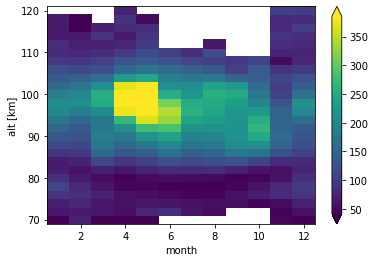

In [12]:
da_jul_gw_total_clim.plot(x = 'month', robust = True)

# GAIA

## Rio

In [13]:
root_path = '/projekt4/hochatm/akuchar/GAIA_analysis/'
infile = f'{root_path}GAIA_Rio_20080201_20141231_run20200327.nc'
ds = xr.open_dataset(infile, group='GAIA')
ds['time'] = pd.date_range(start = '2008-02-01', end = '2014-12-31', periods=ds.time.shape[0])
ds

FileNotFoundError: [Errno 2] No such file or directory: b'/projekt4/hochatm/akuchar/GAIA_analysis/GAIA_Rio_20080201_20141231_run20200327.nc'

### Tides amplitude in zonal wind (climatology)

#### Diurnal

In [ ]:
temp = ds['A24u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Semi-diurnal

In [ ]:
temp = ds['A12u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Terdiurnal

In [ ]:
temp = ds['A8u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

### Gravity waves

In [ ]:
var = 'u'
da_gwu = ds[var]-ds[f'{var}_fil']
var = 'v'
da_gwv = ds[var]-ds[f'{var}_fil']
da_gw_total = 0.5*(da_gwu**2+ da_gwv**2)
da_gw_total_clim = da_gw_total.groupby('time.month').mean('time')
da_gw_total_clim

In [ ]:
da_gw_total.plot(x = 'time', robust = True)

In [ ]:
da_gw_total.sel(alt = slice(60,120)).plot(x = 'time', robust = True)

#### Climatology

In [ ]:
da_gw_total_clim.sel(alt = slice(50,150)).plot(x = 'month', robust = True)